In [23]:
import sys,os
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import json
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%autosave 60
%matplotlib inline

Autosaving every 60 seconds


In [2]:
# Reading the original data
cwd = os.getcwd()
instruction_file_path = "instructions/Analytics_Sample_Data_(3)_(2).xlsx"
data = pd.read_excel(("/").join([cwd, instruction_file_path]))
data.columns = data.columns.str.replace(" ", "_").str.lower()
data.head(3)

,customer_placed_order_datetime,placed_order_with_restaurant_datetime,driver_at_restaurant_datetime,delivered_to_consumer_datetime,driver_id,restaurant_id,consumer_id,is_new,delivery_region,is_asap,order_total,amount_of_discount,amount_of_tip,refunded_amount
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0


In [3]:
def reset(assume_date=False):
    """
    Make a copy of the original data, so we can always revert to the original setting.
    If assume_date=True, the date will be parsed in '2019-03-dd'format. 
    I chose 2019 March for convenience as the largest number of days observed in the data was 31.
    In this way, we can easily retrieve day of the week, week of the year, etc. features too.
    """
    df = data.copy()
    if assume_date:
        def correct_month(row):
            # To fix for incorrect month - there are cases where the day of the delivery 
            # date is smaller than the day when the order is placed by the consumer.
            # I only applied the function on delivered_to_consumer_datetime as two other date columns have missing data. 
            if not row.customer_placed_order_datetime < row.delivered_to_consumer_datetime:
                row.delivered_to_consumer_datetime=row.delivered_to_consumer_datetime.replace(month=4)
            return row
        this_year = str(dt.datetime.now().year)
        operation_month = str("03")
        for col in df.columns[:4]:
            df[col] = this_year + "-" + operation_month + "-" + df[col]
            df[col] = pd.to_datetime(df[col],format='%Y-%m-%d %H:%M:%S')
            
        df = df.apply(lambda x:correct_month(x), axis=1)
        df["total_minutes"] = (df["delivered_to_consumer_datetime"] - df["customer_placed_order_datetime"]).dt.total_seconds()/60
        df["total_hours"] = df["total_minutes"]/60
        df["total_days"] = df["total_hours"]/24
    return df

In [17]:
def plot(value_array, title):
    sns.set(style="ticks")

    x = value_array

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)}, 
                                        figsize=(10,5))
    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
#     ax.set_title(title)

# <font color=red>PART I

## 1. EDA

In [5]:
print ("Total number of rows, cols in the given data:{}".format(data.shape))
print ("Checking for the missing values:")
data.isnull().sum()

Total number of rows, cols in the given data:(18078, 14)
Checking for the missing values:


customer_placed_order_datetime              0
placed_order_with_restaurant_datetime      40
driver_at_restaurant_datetime            4531
delivered_to_consumer_datetime              0
driver_id                                   0
restaurant_id                               0
consumer_id                                 0
is_new                                      0
delivery_region                             0
is_asap                                     0
order_total                                 0
amount_of_discount                          0
amount_of_tip                               0
refunded_amount                             0
dtype: int64

In [6]:
# Data types
data.dtypes

# Data describe
data.describe()

,driver_id,restaurant_id,consumer_id,order_total,amount_of_discount,amount_of_tip,refunded_amount
count,18078.000000,18078.000000,18078.000000,18078.000000,18078.000000,18078.000000,18078.000000
mean,222.448169,108.721263,32010.313475,51.261496,1.356706,3.492022,0.612091
std,105.219194,98.609766,42010.215766,50.599675,6.516667,3.700115,6.073104
min,7.000000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,141.000000,23.000000,4243.500000,26.660000,0.000000,1.400000,0.000000
50%,227.000000,77.000000,10972.000000,38.630000,0.000000,2.550000,0.000000
75%,314.000000,186.000000,56857.000000,57.885000,0.000000,4.460000,0.000000
max,438.000000,409.000000,200449.000000,1604.130000,187.880000,120.300000,414.770000


Total number of unique consumers: 6701
Total number of unique drivers: 295
Total number of unique restaurants: 314
List of delivery regions:['Palo Alto' 'Mountain View' 'San Jose' 'None']


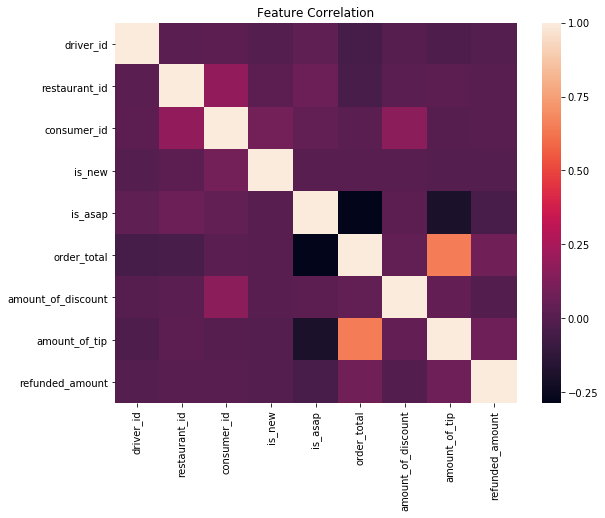

In [7]:
df = reset()
print ("Total number of unique consumers: {}".format(df.consumer_id.nunique()))
print ("Total number of unique drivers: {}".format(df.driver_id.nunique()))
print ("Total number of unique restaurants: {}".format(df.restaurant_id.nunique()))

print ("List of delivery regions:{}".format(df.delivery_region.unique()))

corr = df.corr()
fig, ax = plt.subplots(1,1, figsize=(9,7))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
ax.set_title('Feature Correlation');

__Key Insights:__
>We observe a weak negative correlation between __"is_asap"__ and __"amount_of_tip."__ We can interpret it as people are prone to tip the driver more when they place a scheduled delivery as its total cost is more likely to be cheaper than on-demand delivery. We also observe a stronger negative correlation between __"is_asap"__ and __"order_total"__ for the same reason.


## 2. User & Order Analysis

__Key questions:__
>1.  On average, how many orders do a user make within the same month?
>2.  Is there any difference in the statistics between new users and old users assuming this will be captured by "is_new" feature?

In [8]:
print ("Percentage of the new users who joined the Application this month:{}".format(round(float(df[df.is_new].consumer_id.nunique())/df.consumer_id.nunique(),3)))
first_users = df[df.is_new].groupby('consumer_id').agg({'order_total':['mean', 'max', 'min', 'count'], 
                                                        'amount_of_discount':['mean', 'max','min'],
                                                        'refunded_amount':['mean', 'max','min']})

first_users.sort_values([('order_total', 'count')], ascending=False).head()

Percentage of the new users who joined the Application this month:0.363


order_total                      amount_of_discount                \
                   mean     max    min count               mean    max    min   
consumer_id                                                                     
514           69.740833  150.00  19.57    12          68.929167  150.0  19.57   
2469          35.562222   50.53  25.03     9           0.000000    0.0   0.00   
9798          20.790000   48.41  11.98     9           0.000000    0.0   0.00   
78977         23.708571   24.98  22.31     7           0.000000    0.0   0.00   
459           83.094286  123.36  51.14     7           0.000000    0.0   0.00   

            refunded_amount              
                       mean    max  min  
consumer_id                              
514                0.182500   2.19  0.0  
2469               0.666667   6.00  0.0  
9798               0.000000   0.00  0.0  
78977              0.000000   0.00  0.0  
459                4.011429  28.08  0.0

>If we assumed that a user with a unique "consumer_id" can join the Application only once, we expect to see __"is_new"__ field true at most once for all the users. However, we see that there are a number of users who have "is_new" field true more than once. The first row (consumer_id = 514) conveys another previously unseen pattern. It appears that the user was able to get the discount that is similar to the actually __"order_total."__ Let's take a closer look at this consumer.

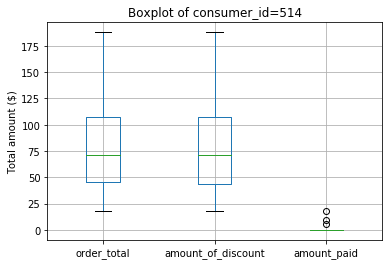

In [9]:
fig, ax = plt.subplots(1,1)
fraud = df[df.consumer_id == 514].reset_index(drop=True)
fraud["amount_paid"] = fraud["order_total"] - fraud["amount_of_discount"]
fraud.boxplot(column=['order_total', 'amount_of_discount', 'amount_paid'])
ax.set_title("Boxplot of consumer_id=514")
ax.set_ylabel("Total amount ($)");

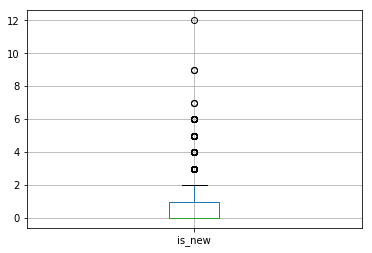

In [10]:
ax, fig = plt.subplots(1,1)
df.groupby('consumer_id').agg({'is_new':'sum'}).boxplot()

In [11]:
fraud_all = df
fraud_all["amount_paid"] = fraud_all["order_total"] - fraud_all["amount_of_discount"]
fraud_all = fraud_all.groupby('consumer_id').agg({'amount_paid':['count','sum','mean'], 
                               'order_total': ['sum','max', 'mean', 'min'],
                               'amount_of_discount': ['sum'],
                               'is_new':['sum']})
fraud_result = fraud_all.sort_values([('amount_paid', 'mean'),
                       ('order_total', 'sum'), 
                       ('amount_of_discount', 'sum'),
                       ('is_new', 'sum')], ascending=[True, False, False, False])
fraud_result.head(20)

amount_paid                  order_total                      \
                  count    sum      mean         sum     max        mean   
consumer_id                                                                
12325                 3   0.00  0.000000      149.41   72.98   49.803333   
7141                  1   0.00  0.000000      121.36  121.36  121.360000   
5                     3   0.00  0.000000       98.85   40.62   32.950000   
1743                  3   0.00  0.000000       87.11   41.98   29.036667   
475                   4   0.00  0.000000       66.71   30.88   16.677500   
16117                 1   0.00  0.000000       61.90   61.90   61.900000   
90223                 1   0.00  0.000000       44.99   44.99   44.990000   
13777                 1   0.00  0.000000       38.46   38.46   38.460000   
3103                  1   0.00  0.000000       36.45   36.45   36.450000   
58227                 1   0.00  0.000000       34.27   34.27   34.270000   
3529                  1   0.00  0.000000       33.68   33.68   33.680000   
415                   1   0.00  0.000000       29.31   29.31   29.310000   
10690                 1   0.00  0.000000       27.75   27.75   27.750000   
14360                 1   0.00  0.000000       27.20   27.20   27.200000   
3251                  1   0.00  0.000000       23.94   23.94   23.940000   
9312                  1   0.00  0.000000       20.03   20.03   20.030000   
67084                 1   0.00  0.000000       17.91   17.91   17.910000   
105412                1   0.00  0.000000       14.16   14.16   14.160000   
7980                  1   0.00  0.000000        0.00    0.00    0.000000   
514                  66  33.67  0.510152     5262.26  187.88   79.731212   

                    amount_of_discount is_new  
                min                sum    sum  
consumer_id                                    
12325         32.39             149.41    0.0  
7141         121.36             121.36    0.0  
5             20.45              98.85    0.0  
1743          16.31              87.11    1.0  
475           10.33              66.71    1.0  
16117         61.90              61.90    0.0  
90223         44.99              44.99    0.0  
13777         38.46              38.46    0.0  
3103          36.45              36.45    0.0  
58227         34.27              34.27    0.0  
3529          33.68              33.68    0.0  
415           29.31              29.31    0.0  
10690         27.75              27.75    0.0  
14360         27.20              27.20    0.0  
3251          23.94              23.94    1.0  
9312          20.03              20.03    0.0  
67084         17.91              17.91    0.0  
105412        14.16              14.16    0.0  
7980           0.00               0.00    0.0  
514           18.45            5228.59   12.0

__Recommendation:__

The result above shows that there are many cases where the total amount_paid euals or almost equals the total amount_of_discount. This could be happening due to some users who accumulated promo code or credit over a long period of time, especially if they are not newly registered users. Therefore, we cannot merely flag the accounts whose total __"amount_of_discount"__ = total __"order_total"__ as fraud. To minimize the undesired false positives, we will have a more restricted rule on determining fraudulent activity such as the following:

* If percent_discounted = (amount_of_discount / order_total) > 95%, suspected_temp = 1, otherwise 0
* If percent_suspected_activities = (Number of transactions where (amount_of_discount / order_total) > 95 % is true) / Total number of transactions > 80%, suspect fraud where Total number of transactions > 1
* If we apply this rule, we can find one user (consumer_id=514) who is suspected to be fraud.

In [12]:
# %%
df = reset()
df["percent_discounted"] = df["amount_of_discount"] / df["order_total"]
df["suspected_temp"] = np.where(df["percent_discounted"] >= 0.95, 1, 0)
df = df.groupby('consumer_id').agg({'suspected_temp':'sum', 'order_total':['count', 'sum']})
df['percent_suspected_activities'] = df[('suspected_temp', 'sum')]/df[('order_total', 'count')]

df_result = df[(df.percent_suspected_activities > 0.8) & (df[('order_total', 'count')] > 1)]
print ("Total amount of dollars (risk) that can be saved by detecting the fraud: ${}".format(\
                round(df_result[('order_total', 'sum')].sum(),2)))
df_result

Total amount of dollars (risk) that can be saved by detecting the fraud: $5664.34


suspected_temp order_total          percent_suspected_activities
                       sum       count      sum                             
consumer_id                                                                 
5                        3           3    98.85                     1.000000
475                      4           4    66.71                     1.000000
514                     63          66  5262.26                     0.954545
1743                     3           3    87.11                     1.000000
12325                    3           3   149.41                     1.000000

## 3. Driver & Restaurant Analysis

__Key Question: On average, how long does it take for a dasher to make a delivery if the order were not scheduled in advance?__

>The time taken for a delivery is an important metric related to customer satisfaction. Especially for the on-demand orders, our clients would like to recieve the delivery as soon as possible. On average, dashers are taking 46.89 minutes to make a delivery for on-demand orders, and this statistic looks reasonable.

>To check for an outlier, histogram and boxplot of the "total_hours" are generated. The plot evidently shows that there is an outlier (~70 hours). When we took a closer look at the point, we could find that the delivery was made by driver_id = 216. According to the histogram of his on-demand order delivery time distribution, it appears that this anomaly happend only once, and thus does not seem to be fradulent. However, it is strongly recommended to investigate what caused this anomaly - could be some logging error.

In [14]:
df_driver = reset(True)
print ("Avg time taken for an on-demand delivery: {}".format(round(df_driver[df_driver.is_asap].total_minutes.mean(),2)))

Avg time taken for an on-demand delivery: 46.89


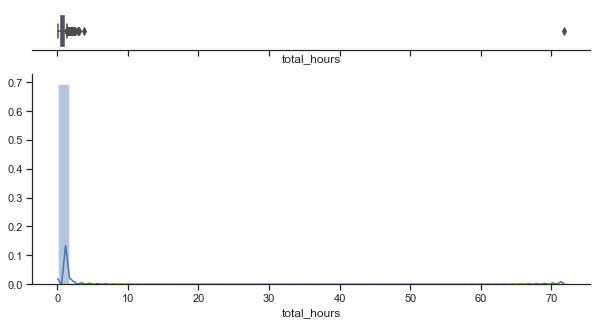

In [19]:
# Delivery distribution across all dashers (with outliers)
plot(df_driver[df_driver.is_asap]["total_hours"], title = "Delivery distribution across all dashers (with outliers)")

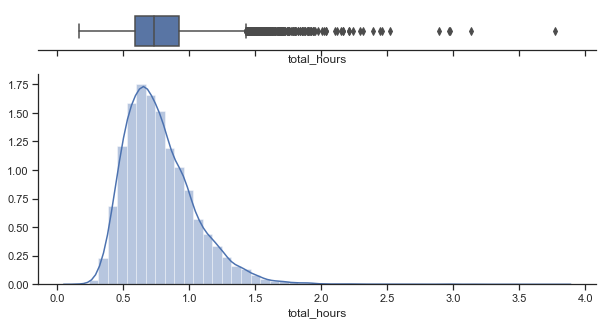

In [20]:
# Delivery time distribution without the outlier
plot(df_driver[(df_driver.is_asap) & (df_driver.total_hours < 70)]["total_hours"],
    title ="Delivery time distribution without the outlier")

In [21]:
df_driver[df_driver.is_asap].sort_values("total_days", ascending=False).head()

,customer_placed_order_datetime,placed_order_with_restaurant_datetime,driver_at_restaurant_datetime,delivered_to_consumer_datetime,driver_id,restaurant_id,consumer_id,is_new,delivery_region,is_asap,order_total,amount_of_discount,amount_of_tip,refunded_amount,total_minutes,total_hours,total_days
14810,2019-03-10 00:08:16,2019-03-12 20:08:14,2019-03-12 23:17:26,2019-03-12 23:56:23,216,9,85535,False,Palo Alto,True,358.04,6.0,15.91,0.0,4308.116667,71.801944,2.991748
10345,2019-03-27 00:37:43,2019-03-27 00:52:25,NaT,2019-03-27 04:24:10,73,140,14203,True,San Jose,True,21.12,0.0,1.06,0.0,226.450000,3.774167,0.157257
5554,2019-03-22 16:20:59,2019-03-22 17:58:04,2019-03-22 18:23:59,2019-03-22 19:29:01,114,19,6710,True,Palo Alto,True,178.66,0.0,7.66,0.0,188.033333,3.133889,0.130579
11297,2019-03-30 01:20:55,2019-03-30 01:21:41,2019-03-30 01:31:19,2019-03-30 04:19:30,397,39,26597,False,Mountain View,True,38.08,0.0,1.90,0.0,178.583333,2.976389,0.124016
13203,2019-03-13 15:58:57,2019-03-13 17:56:45,2019-03-13 18:24:39,2019-03-13 18:57:01,303,96,64746,True,Palo Alto,True,76.14,0.0,6.45,0.0,178.066667,2.967778,0.123657


## 4. Other Approaches

__Using the Order Frequency:__ We can compute on average how often a user makes an order to analyze their order habit. - Select a user who has ordered more than twice through Doordash, create a column that would count the number of days taken between the latest order and previous order, take the average. </font>

In [24]:
df = reset(True)
df["day"] = df.customer_placed_order_datetime.dt.day
df.sort_values(inplace=True, by='customer_placed_order_datetime')
test = df.groupby('consumer_id')
test_2 = test.get_group(5)
test_2["frequency"] =  test_2["day"] - test_2["day"].shift(1)
test_2.head()

,customer_placed_order_datetime,placed_order_with_restaurant_datetime,driver_at_restaurant_datetime,delivered_to_consumer_datetime,driver_id,restaurant_id,consumer_id,is_new,delivery_region,is_asap,order_total,amount_of_discount,amount_of_tip,refunded_amount,total_minutes,total_hours,total_days,day,frequency
1,2019-03-07 20:16:28,2019-03-07 20:17:32,2019-03-07 20:36:00,2019-03-07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0,32.566667,0.542778,0.022616,7,NaN
2,2019-03-13 19:35:09,2019-03-13 19:39:26,2019-03-13 20:28:16,2019-03-13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0,77.583333,1.293056,0.053877,13,6.0
0,2019-03-14 20:27:45,2019-03-14 20:29:41,2019-03-14 20:39:32,2019-03-14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0,24.300000,0.405000,0.016875,14,1.0


Using order frequency vs. order total: It is recommended to pay extra attention to the outliers in this plot. Also, this plot would be useful for segmenting the customers before strategizing promotions. For example, we can provide more promotion (discounts) to the users who are placing high value order, but not often or users who are placing low value order, but very often.

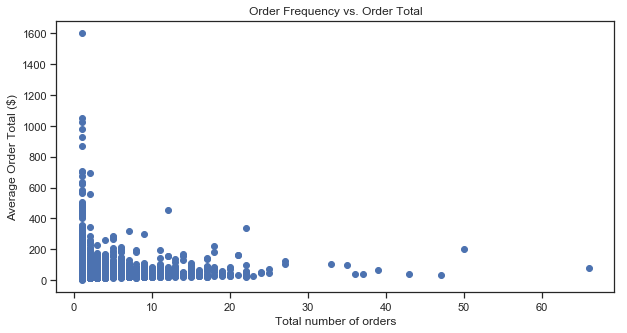

In [26]:
t = df.groupby('consumer_id').agg({'order_total':['mean', 'max', 'min', 'count']})
t.columns=t.columns.droplevel()
t=t.reset_index()
t

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("Order Frequency vs. Order Total")
ax.set_xlabel("Total number of orders")
ax.set_ylabel("Average Order Total ($)")
ax.scatter(x=t["count"], y=t["mean"]);

Using the overall Time Series Analysis: Calculate the overall average of order amount or order total given day of week. If a significant departure from the average value is observed, flag as fraud </font>

In [27]:
df = reset(assume_date=True)
df["day_of_week"] = df['customer_placed_order_datetime'].apply(lambda x:x.isoweekday())
df["week_number"] = df.customer_placed_order_datetime.dt.week
df.head(1)

,customer_placed_order_datetime,placed_order_with_restaurant_datetime,driver_at_restaurant_datetime,delivered_to_consumer_datetime,driver_id,restaurant_id,consumer_id,is_new,delivery_region,is_asap,order_total,amount_of_discount,amount_of_tip,refunded_amount,total_minutes,total_hours,total_days,day_of_week,week_number
0,2019-03-14 20:27:45,2019-03-14 20:29:41,2019-03-14 20:39:32,2019-03-14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0,24.3,0.405,0.016875,4,11


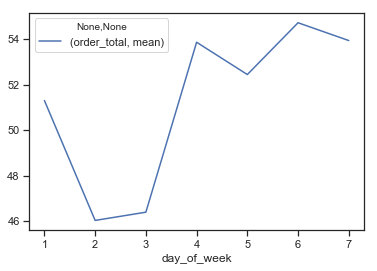

In [28]:
df.groupby('day_of_week').agg({'order_total':['mean']}).plot();

# <font color=red> PART 2 </font>

**Creating a view is recommended because it is highly likley that this table will be queried often across different teams at Doordash. To reinforce the speed, creating an index on Dasher id is high recommended.**

CREATE VIEW DashEarning AS
SELECT Dash.*, 
       DATE_FORMAT(dash_start_time, '%Y-%m-%d') AS date_only, 
       DATE_FORMAT(dash_start_time,'%H:%i:%s') AS time_only,
       total_pay / (TIMESTAMPDIFF(MINUTE, Dash.dash_start_time, Dash.dash_end_time)/60) AS earning_hr, 
       DAYOFWEEK(Dash.dash_start_time) AS dash_dow
FROM Dash 
JOIN Dasher ON Dash.dasher_id = Dasher.id

#### (a) Write a query to calculate the average earnings per hour by day of week.

In [ ]:
SELECT AVG(earning_hr) FROM DashEarning
GROUP BY dash_dow

#### (b) Calculate the average earnings per hour during lunch (11AM-2PM) in submarket_id 3.

Assume a homogeneous poisson process is observed for lunch time:

In [ ]:
SELECT AVG((TIME_TO_SEC(TIMEDIFF(end, start))/3600) * earning_hr) AS lunch_avg_earning_hr
FROM 

    (SELECT earning_hr,
           CASE WHEN '11:00:00' > dash_start_time THEN '11:00:00'
           ELSE dash_start_time
           END AS start,

           CASE WHEN '14:00:00' > dash_end_time THEN 'dash_end_time'
           ELSE '14:00:00'
           END AS end 
    FROM DashEarning
    WHERE submarket_id = 3) AS lunch_dash

#### (c) Target dashers who are in the bottom 50th percentile of total pay/hour in the last 30days with promotion. Dashers with their email address.

In [ ]:
SELECT TOP 50 PERCENT dasher_id, email_address FROM DashEarning
WHERE (dash_start_time BETWEEN NOW() - INTERVAL 30 DAY AND NOW())
ORDER BY total_pay ASC